In [2]:
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import pairwise
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# note that this notebook requires de_per_donor that needs to be generated with run_limma.R. run_limma.R requires pseudobulk_cleaned.h5ad, which is generated using the corresponding script from https://github.com/openproblems-bio/task_perturbation_prediction repository
!aws s3 cp s3://openproblems-bio/public/neurips-2023-competition/workflow-resources/neurips-2023-data/de_test.h5ad ../data/de_test.h5ad --no-sign-request

download: s3://openproblems-bio/public/neurips-2023-competition/workflow-resources/neurips-2023-data/de_test.h5ad to ../data/de_test.h5ad


In [6]:
data_path = "../data/neurips-2023-data/de_per_donor.h5ad"

In [7]:
adata = ad.read_h5ad(data_path)

In [8]:
# add mse on the pseudobulk to the metrics
adata_pseudobulk = ad.read_h5ad("../data/neurips-2023-data/pseudobulk_cleaned.h5ad")

In [9]:
adata_pseudobulk.obs["sm_cell_type_donor"] = adata_pseudobulk.obs["sm_name"].astype(str) + "_" + adata_pseudobulk.obs["cell_type"].astype(str) + "_" + adata_pseudobulk.obs["donor_id"].astype(str)
adata_pseudobulk.obs.sm_cell_type_donor = adata_pseudobulk.obs.sm_cell_type_donor.astype("category")

In [10]:
# normalize by cell count
adata_pseudobulk.X = adata_pseudobulk.X / adata_pseudobulk.obs["cell_count_by_well_celltype"].values[:, None]

In [11]:
adata_pseudobulk.X = adata_pseudobulk.X.todense()

In [12]:
X_df = pd.DataFrame(adata_pseudobulk.X, index=adata_pseudobulk.obs.index, columns=adata_pseudobulk.var_names)
grouped_means = X_df.groupby(adata_pseudobulk.obs['sm_cell_type_donor']).mean()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_67284/3261264666.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_df.groupby(adata_pseudobulk.obs['sm_cell_type_donor']).mean()


In [13]:
adata.layers["log_counts"] = np.log1p(grouped_means.loc[adata.obs.sm_cell_type_donor].values)

In [14]:
threshold_log10pval = -np.log10(0.0001)
threshold_pval = 0.0001
# clip all of the values at 0.0001
adata.layers["P.Value_notclipped"] = adata.layers["P.Value"].copy()
adata.layers["P.Value"] = np.clip(adata.layers["P.Value"], a_min=threshold_pval, a_max=1)
adata.layers["adj.P.Value"] = np.clip(adata.layers["adj.P.Value"], a_min=threshold_pval, a_max=1)
adata.layers["sign_log10_pval"] = np.clip(adata.layers["sign_log10_pval"], a_min=-threshold_log10pval, a_max=threshold_log10pval)
adata.layers["sign_log10_nonadj_pval"] = np.clip(adata.layers["sign_log10_nonadj_pval"], a_min=-threshold_log10pval, a_max=threshold_log10pval)

In [15]:
adata.layers['is_de_005'] = adata.layers.pop('is_de')

# Rename the existing is_de_adj layer (assuming it was intended for adj.P.Value with 0.05 threshold)
adata.layers['is_de_adj_005'] = adata.layers.pop('is_de_adj')

# Define your other P.Value thresholds (excluding 0.05 since it's already handled)
p_value_thresholds = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001, 1e-10]  # Add other thresholds as needed

# Loop through each threshold and create a new layer
for threshold in p_value_thresholds:
    # Create a new layer name based on the threshold
    layer_name = f'is_de_{str(threshold).replace(".", "")}'
    
    # Calculate the new layer values based on the threshold and sign of logFC
    adata.layers[layer_name] = np.where(
        (adata.layers['P.Value_notclipped'] < threshold),
        np.sign(adata.layers['logFC']),
        0
    )
logfc_thresholds = [1, 1.5, 2, 3]

# Loop through each logFC threshold and create a new layer
for threshold in logfc_thresholds:
    # Create a new layer name based on the logFC threshold
    layer_name = f'sign_log10_nonadj_pval_logfc_gt_{str(threshold).replace(".", "")}'
    
    # Calculate the new layer values based on the logFC threshold and sign of sign_log10_nonadj_pval
    adata.layers[layer_name] = np.where(
        (np.abs(adata.layers['logFC']) > threshold),
        adata.layers['sign_log10_nonadj_pval'],
        0
    )

In [16]:
def calculate_mse(single_data, multiple_data):
    squared_diffs = (single_data - multiple_data) ** 2
    mse_results = np.mean(squared_diffs, axis=1)
    return np.expand_dims(mse_results, axis=0)

In [17]:
def calculate_mae(single_data, multiple_data):
    abs_diffs = np.abs(single_data - multiple_data)
    mae_results = np.mean(abs_diffs, axis=1)
    return np.expand_dims(mae_results, axis=0)

In [18]:
ranks = {
    'signature': [],
    'cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'sm_name': [],
    'rank_cosine': [],
    'rank_mae': [],
    'rank_mse': []
}

# Iterate over each layer (signature) to calculate cosine similarities
for signature in adata.layers.keys():
    print(f"Processing signature: {signature}")
    for cell_type in adata.obs['cell_type'].unique():
        # Filter data by sm_cell_type
        cell_type_adata = adata[adata.obs['cell_type'] == cell_type]
        sm_names = cell_type_adata.obs['sm_name'].unique()

        # Get unique donors within this sm_cell_type
        donors = cell_type_adata.obs['donor_id'].unique()

        # Iterate over all combinations of two different donors
        for donor_id_1, donor_id_2 in itertools.combinations(donors, 2):
            # Filter data for each donor
            donor_data_1 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_1]
            donor_data_2 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_2]
            
            for sm_name in donor_data_1.obs['sm_name'].unique():
                if sm_name not in donor_data_2.obs['sm_name'].unique():
                    continue
                # get index of sm_name in donor_data_2
                idx = np.where(donor_data_2.obs['sm_name'] == sm_name)[0][0]
                data1 = donor_data_1[donor_data_1.obs['sm_name'] == sm_name].layers[signature].astype(float)
                data2 = donor_data_2.layers[signature].astype(float)
                cosine_similarity = pairwise.cosine_similarity(
                    data1,
                    data2
                )
                # pairwise MAE
                mae = calculate_mae(data1, data2)
                mse = calculate_mse(data1, data2)
                rank_cosine = np.where(np.argsort(-cosine_similarity) == idx)[1][0]
                rank_mae = np.where(np.argsort(mae) == idx)[1][0]
                rank_mse = np.where(np.argsort(mse) == idx)[1][0]
                ranks['signature'].append(signature)
                ranks['cell_type'].append(cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['sm_name'].append(sm_name)
                ranks['rank_cosine'].append(rank_cosine)
                ranks['rank_mae'].append(rank_mae)
                ranks['rank_mse'].append(rank_mse)

# Convert ranks to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: P.Value
Processing signature: adj.P.Value
Processing signature: logFC
Processing signature: sign_log10_nonadj_pval
Processing signature: sign_log10_pval
Processing signature: log_counts
Processing signature: P.Value_notclipped
Processing signature: is_de_005
Processing signature: is_de_adj_005
Processing signature: is_de_001
Processing signature: is_de_0005
Processing signature: is_de_0001
Processing signature: is_de_00005
Processing signature: is_de_00001
Processing signature: is_de_1e-05
Processing signature: is_de_1e-10
Processing signature: sign_log10_nonadj_pval_logfc_gt_1
Processing signature: sign_log10_nonadj_pval_logfc_gt_15
Processing signature: sign_log10_nonadj_pval_logfc_gt_2
Processing signature: sign_log10_nonadj_pval_logfc_gt_3


In [62]:
# filter to only "signature" starting with "is_de" or "sign_log10_nonadj_pval"
ranks_df_subset = ranks_df[ranks_df['signature'].str.startswith('is_de') | (ranks_df['signature'] == 'sign_log10_nonadj_pval')].copy()

In [63]:
def rename_signature(signature):
    if signature == 'sign_log10_nonadj_pval':
        return 'Sign log10(P-value)'
    elif signature.startswith('is_de'):
        threshold = signature.split('_')[-1]
        if threshold.startswith('0'):
            threshold = f".{threshold[1:]}"
        return f'DE {threshold}'
    else:
        return signature

# Apply the function to rename the 'signature' column
ranks_df_subset['signature'] = ranks_df_subset['signature'].apply(rename_signature)

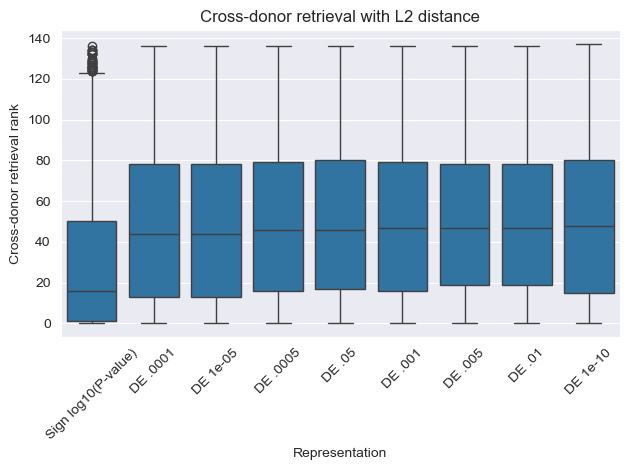

In [65]:
ordered_signatures = ranks_df_subset.groupby('signature')['rank_mse'].median().sort_values().index
sns.boxplot(data=ranks_df_subset, x='signature', y='rank_mse', order=ordered_signatures)
plt.xticks(rotation=45)
plt.ylabel('Cross-donor retrieval rank')
plt.title('Cross-donor retrieval with L2 distance')
plt.xlabel('Representation')
# make tight
plt.tight_layout()
plt.savefig("suppfig_binarized_rep.pdf", transparent=True)
plt.show()